# Install Dependencies

In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import datetime
import librosa
import seaborn as sn
import pandas as pd
import sklearn
import itertools
import plotly.express as px
import plotly.graph_objects as go


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, LSTM
from keras.layers import Rescaling
from keras.utils import to_categorical
from keras import backend as K
from keras.callbacks import Callback
from IPython.display import Audio, display


dataset_path = "/content/drive/MyDrive/Extended_Essay/Data_GZAN/genres_original"

music_genres_list = ['blues', 'classical', 'country', 'disco',
                     'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

%cd /content/drive/MyDrive/Extended_Essay/Data_GZAN/mfcc_data

/content/drive/MyDrive/Extended_Essay/Data_GZAN/mfcc_data


# Prepare MFCC data save data to disk

In [ ]:


def get_audio_files(audio_file_dir):
  num_tracks = len(os.listdir(audio_file_dir))  # find number of audio tracks in dataset
  audio_file_dims = (20,1293)  #specify input audio size
  desired_time_frames = audio_file_dims[1]
  dataset = np.zeros(shape=(num_tracks, audio_file_dims[0], audio_file_dims[1]))  # creates empty array of batches size (1000, 20, 1293)
                                                                           # indicates (num_audio_files, mfcc_num(features/timestep), time_steps)

  for file_index, file_name in enumerate(os.listdir(audio_file_dir)):  # enumerate listing of audio_file_dir
    output_audio_path = f"{audio_file_dir}/{file_name}"
    print(output_audio_path)

    # load audio file from librosa and obtained mfcc features
    audio, sampling_rate = librosa.load(output_audio_path)
    mfcc_features = librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=20, hop_length=512)  #n_mfcc means number of features per time step/length. 512 as hope_length is actually the default

    # Get the current length of the MFCC sequence
    current_length = mfcc_features.shape[1]

    # pad mfcc features if less than desired time_frames
    if current_length < desired_time_frames:
        # Calculate the amount of padding needed
        pad_length = desired_time_frames - current_length

        # Pad the MFCC sequence with zeros along the time axis
        mfcc_features = np.pad(mfcc_features, ((0, 0), (0, pad_length)), mode='constant', constant_values=0)

    # cut mfcc features if more than desired time_frames
    elif current_length > desired_time_frames:
      mfcc_features = mfcc_features[:, :desired_time_frames]

    # Apply CMVN normalization
    mean = np.mean(mfcc_features, axis=1)
    std_dev = np.std(mfcc_features, axis=1)
    mfcc_features = (mfcc_features - mean[:, np.newaxis]) / std_dev[:, np.newaxis]

    dataset[file_index] = mfcc_features # replace specific index of dataset to numpy, audio features array

  return np.array(dataset) # return array of the dataset

def get_dataset(dataset_dir):
  input_data = [] # create some empty variables
  target_labels = []
  genre_index = 0

  for music_genre in music_genres_list:
    genre_numpy_data = get_audio_files(f"{dataset_dir}/{music_genre}") # get images from each directory


    num_tracks = len(genre_numpy_data)
    num_classes = len(music_genres_list)
    ground_truths = np.zeros(shape=(num_tracks, num_classes)) # create empty array of 1000 tracks and 10 classes --> np.shape() = (1000, 10)
    input_data.append(genre_numpy_data) # add to overall list to convert to giant np array later

    for index in range(ground_truths.shape[0]): # for each audio track, change the value of the 10 array and put in a 1 for its class position (genre_index)
      ground_truths[index, genre_index] = 1


    target_labels.append(ground_truths) # add to overall list to convert to giant np array later again
    genre_index += 1 # iterate to next music genre

  print(input_data[9].shape)
  input_data = np.vstack(input_data) # concatenate all classes
  target_labels = np.vstack(target_labels)

  # take an example from dataset for a sanity check
  example_num = 310
  print(f"predict data shape: {input_data.shape}\ntarget labels shape: {target_labels.shape}")
  print(f"Example input size: {input_data[example_num].shape}\nExample target_label {target_labels[example_num]}")

  return input_data, target_labels


mfcc_train, mfcc_targets = get_dataset(dataset_path)
print(f"\n\nLoaded train dataset: {mfcc_train.shape}, {mfcc_targets.shape}")

In [ ]:
# save mfcc data to disk
np.save('mfcc_train.npy', mfcc_train)
np.save('mfcc_targets.npy', mfcc_targets)

NameError: ignored

# Load MFCC data if saved on disk

In [2]:
mfcc_train = np.load('mfcc_train.npy')
print(mfcc_train.shape)
mfcc_targets = np.load('mfcc_targets.npy')
print(mfcc_targets.shape)

(1000, 20, 1293)
(1000, 10)


# Load seperate data for each genre

In [ ]:
def seperate_genre_data(train_dataset):
  # make a placeholder that we can modify without worrying
  placeholder_dataset = train_dataset
  num_tracks_per_genre = {}
  genre_individual_data = {}

  # get num of tracks per genre and save to a directory
  for music_genre in music_genres_list:
    genre_directory = f"/content/drive/MyDrive/Extended_Essay/Data_GZAN/genres_original/{music_genre}"
    count = 0
    # Iterate directory
    for path in os.listdir(genre_directory):
        # check if current path is a file
        if os.path.isfile(os.path.join(genre_directory, path)):
            count += 1

    # add to overall dictionary and continously modify the placeholder dataset
    genre_individual_data[music_genre] = placeholder_dataset[:count]
    placeholder_dataset = placeholder_dataset[count:]

  return genre_individual_data

genre_seperate_data = seperate_genre_data(mfcc_train)

In [ ]:
num_classes = 10
feature_height = 20
sequence_length = 1293
LSTM_units = 20

# define some of the metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision



mfcc_model = Sequential()
mfcc_model.add(LSTM(units=LSTM_units, input_shape=(feature_height, sequence_length)))  # units define the output space. the LSTM knows that it must process 1293 sequences
mfcc_model.add(Dense(units=num_classes, activation='softmax'))

mfcc_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision_m, recall_m])
mfcc_model.summary()


batch_size = 32
epochs = 20

class CustomEarlyStopping(Callback):
    def __init__(self, target_accuracy=1.0):
        super(CustomEarlyStopping, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= self.target_accuracy:
            print(f"\nReached target accuracy ({self.target_accuracy}). Training stopped.")
            self.model.stop_training = True

# Define custom early stopping callback
custom_early_stopping = CustomEarlyStopping(target_accuracy=1.0)

# Experiment with epochs or batch_size!
history = mfcc_model.fit(
    x=mfcc_train,
    y=mfcc_targets,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[custom_early_stopping]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                105120    
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
Total params: 105330 (411.45 KB)
Trainable params: 105330 (411.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
25/25 [==============================] - 4s 79ms/step - loss: 2.3439 - accuracy: 0.1000 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.4874 - val_accuracy: 0.0400 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/20
25/25 [==============================] - 1s 40ms/step - loss: 1.8302 - accuracy: 0.5700 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.595

# Click for Small



In [ ]:
num_classes = 10
feature_height = 20
sequence_length = 1293
LSTM_units = 20

# define some of the metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

mfcc_model = Sequential()
mfcc_model.add(LSTM(units=LSTM_units, input_shape=(feature_height, sequence_length)))  # units define the output space. the LSTM knows that it must process 1293 sequences
mfcc_model.add(Dense(units=num_classes, activation='softmax'))

mfcc_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision_m, recall_m])
mfcc_model.summary()

batch_size = 32
epochs = 20

class CustomEarlyStopping(Callback):
    def __init__(self, target_accuracy=1.0):
        super(CustomEarlyStopping, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= self.target_accuracy:
            print(f"\nReached target accuracy ({self.target_accuracy}). Training stopped.")

# Define custom early stopping callback
custom_early_stopping = CustomEarlyStopping(target_accuracy=1.0)

# Experiment with epochs or batch_size!
history = mfcc_model.fit(
    x=mfcc_train,
    y=mfcc_targets,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[custom_early_stopping]
)



Plot learning curves

In [ ]:
#burrowed from https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('LSTM (Small) Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
#plt.legend(['train', 'validation'], loc='upper left')
plt.ylim(0, 1.2)  # Set the y-axis limit from 0 to 1.2
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('LSTM (Small) loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
#plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Create confusion matrix

In [ ]:
%cd /content/drive/MyDrive/Extended_Essay/Data_GZAN/mfcc_data
padd_data = True

def get_confusion_matrix():
  # create some empty variables
  correct_classifications_dict = {}
  y_true = []
  y_predictions = []

  # recall the seperate data we loaded from the start
  for music_genre in genre_seperate_data:
    genre_index = music_genres_list.index(music_genre)
    correct_counter = 0

    # load data from that seperate dataset we created earlier
    mfcc_test_features = genre_seperate_data[music_genre]

    # perform predictions
    predictions = mfcc_model.predict(mfcc_test_features)

    # account for padding
    if music_genre == 'classical' and padd_data == True:
      empty_array = np.array([[0,0,0,0,0,1,0,0,0,0]])
      predictions = np.vstack((predictions, empty_array))

    # Finding the index of the maximum value along each prediction scores
    max_indices = np.argmax(predictions, axis=1)

    for predicted_label in max_indices:
      # add to correct counter if scored correctly
      if predicted_label == genre_index:
        correct_counter += 1

      # add to previous dictionaries and list for confusion matrix later
      y_true.append(music_genre)
      y_predictions.append(music_genres_list[predicted_label])


    correct_classifications_dict[music_genre] = correct_counter

  # create the confusion matrix using sklearn
  generated_conf_matrix = sklearn.metrics.confusion_matrix(y_true,y_predictions)

  return generated_conf_matrix, correct_classifications_dict

mfcc_conf_matrix, correct_dict = get_confusion_matrix()
print(mfcc_conf_matrix)
print(correct_dict)

Display confusion matrix

In [ ]:
# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(mfcc_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('LSTM (Small) Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(music_genres_list))
plt.xticks(tick_marks, music_genres_list, rotation=45)
plt.yticks(tick_marks, music_genres_list)

# Annotate each cell with the numeric value
for i in range(len(music_genres_list)):
    for j in range(len(music_genres_list)):
        text_color = 'white' if mfcc_conf_matrix[i, j] > np.max(mfcc_conf_matrix) / 2 else 'black'
        plt.text(j, i, str(mfcc_conf_matrix[i, j]), horizontalalignment='center',
                 verticalalignment='center', color=text_color)

plt.tight_layout()
plt.ylabel('True genre')
plt.xlabel('Predicted genre')

plt.show()

Get last hidden states, apply TSNE and get centroids



In [ ]:
%cd /content/drive/MyDrive/Extended_Essay/Data_GZAN/mfcc_data

# Define a new model to extract the last hidden state output
last_hidden_state_model = keras.models.Model(inputs=mfcc_model.input, outputs=mfcc_model.layers[0].output)


def get_hidden_states():
  # create some empty variables
  hidden_state_list = []
  genre_track_num = {}

  # recall the seperate data we loaded from the start
  for music_genre in genre_seperate_data:
    # load data from that seperate dataset we created earlier
    mfcc_test_features = genre_seperate_data[music_genre]
    # get hidden states
    last_hidden_state_outputs = last_hidden_state_model.predict(mfcc_test_features)
    # save to list to plot later and count how many tracks there are for each genre
    hidden_state_list.append(last_hidden_state_outputs)
    genre_track_num[f"{music_genre}"] = last_hidden_state_outputs.shape[0]

  # flatten list of lists into numpy array
  hidden_states_array = np.vstack((hidden_state_list))

  return genre_track_num, hidden_states_array

genres_totals, raw_hidden_states = get_hidden_states()

In [ ]:
# transform hidden states dimensions of 20 to 2 so we can plot it.
# use TSNE dimensionality reduction algorithm to reduce size from (100,20) --> (100,2)
%cd /content/drive/MyDrive/Extended_Essay/Data_GZAN/mfcc_data

tsne_model = sklearn.manifold.TSNE(learning_rate='auto', perplexity=50)
transformed_values = tsne_model.fit_transform(raw_hidden_states)

TSNE_dict = {}

for music_genre in genres_totals:
  num_tracks = genres_totals[music_genre]
  TSNE_dict[music_genre] = transformed_values[:num_tracks]
  transformed_values = transformed_values[num_tracks:]

/content/drive/MyDrive/Extended_Essay/Data_GZAN/mfcc_data


In [ ]:
genre_centroids = {}

# find the average central point of each genre
for genre in TSNE_dict:
  # get each data for each genre
  data = TSNE_dict[genre]

  # calculate mean_x/y then add to dictionary
  mean_x = np.mean(data[:, 0])
  mean_y = np.mean(data[:, 1])
  centroid = np.array([mean_x, mean_y])

  # calculate euclidean distance (also called L2 norm) from the calculate centroid
  total = 0
  for datapoint in data:
    distance = np.linalg.norm(centroid-datapoint)
    total += distance

  # calculate average distance from centroid
  average_distance = total / len(data)
  genre_centroids[genre] = centroid

Plot Hidden State

In [ ]:
# Plotting each label's data points using plotly library
fig = px.scatter()

# Add traces for each label's data points
for label, data_points in TSNE_dict.items():
    fig.add_scatter(x=data_points[:, 0], y=data_points[:, 1], mode='markers', name=label)

# configure plot layout
fig.update_layout(
    title='LSTM (Small) Song Representations',
    xaxis_title='X-axis',
    yaxis_title='Y-axis'
)

# Add centroids to the plot
for genre in genre_centroids:
    fig.add_trace(go.Scatter(
        x=[genre_centroids[genre][0]],
        y=[genre_centroids[genre][1]],
        mode='markers',
        marker=dict(size=15, symbol='star', line=dict(color='black', width=2)),
        showlegend=False
    ))

fig.show()

# Click for Big



In [ ]:
num_classes = 10
feature_height = 20
sequence_length = 1293
LSTM_units = 20

# define some of the metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

mfcc_model = Sequential()
 # LSTM units define the output space. the LSTM knows that it must process 1293 sequences
mfcc_model.add(LSTM(units=LSTM_units, return_sequences=True, input_shape=(feature_height, sequence_length)))
mfcc_model.add(LSTM(units=LSTM_units))  # Stack another LSTM layer
mfcc_model.add(Dense(units=num_classes, activation='softmax'))

mfcc_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision_m, recall_m])
mfcc_model.summary()

batch_size = 32
epochs = 20

class CustomEarlyStopping(Callback):
    def __init__(self, target_accuracy=1.0):
        super(CustomEarlyStopping, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= self.target_accuracy:
            print(f"\nReached target accuracy ({self.target_accuracy})")

# Define custom early stopping callback
custom_early_stopping = CustomEarlyStopping(target_accuracy=1.0)

# Experiment with epochs or batch_size!
history = mfcc_model.fit(
    x=mfcc_train,
    y=mfcc_targets,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[custom_early_stopping]
)


Plot learning curves

In [ ]:
#burrowed from https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('LSTM (Big) Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
#plt.legend(['train', 'validation'], loc='upper left')
plt.ylim(0, 1.2)  # Set the y-axis limit from 0 to 1.2
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('LSTM (Big) loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
#plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Create confusion matrix

In [ ]:
%cd /content/drive/MyDrive/Extended_Essay/Data_GZAN/mfcc_data
padd_data = True

def get_confusion_matrix():
  # create some empty variables
  correct_classifications_dict = {}
  y_true = []
  y_predictions = []

  # recall the seperate data we loaded from the start
  for music_genre in genre_seperate_data:
    genre_index = music_genres_list.index(music_genre)
    correct_counter = 0

    # load data from that seperate dataset we created earlier
    mfcc_test_features = genre_seperate_data[music_genre]

    # perform predictions
    predictions = mfcc_model.predict(mfcc_test_features)

    # account for padding
    if music_genre == 'classical' and padd_data == True:
      empty_array = np.array([[0,0,0,0,0,1,0,0,0,0]])
      predictions = np.vstack((predictions, empty_array))

    # Finding the index of the maximum value along each prediction scores
    max_indices = np.argmax(predictions, axis=1)

    for predicted_label in max_indices:
      # add to correct counter if scored correctly
      if predicted_label == genre_index:
        correct_counter += 1

      # add to previous dictionaries and list for confusion matrix later
      y_true.append(music_genre)
      y_predictions.append(music_genres_list[predicted_label])


    correct_classifications_dict[music_genre] = correct_counter

  # create the confusion matrix using sklearn
  generated_conf_matrix = sklearn.metrics.confusion_matrix(y_true,y_predictions)

  return generated_conf_matrix, correct_classifications_dict

mfcc_conf_matrix, correct_dict = get_confusion_matrix()
print(mfcc_conf_matrix)
print(correct_dict)

Display confusion matrix

In [ ]:
# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(mfcc_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('LSTM (Big) Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(music_genres_list))
plt.xticks(tick_marks, music_genres_list, rotation=45)
plt.yticks(tick_marks, music_genres_list)

# Annotate each cell with the numeric value
for i in range(len(music_genres_list)):
    for j in range(len(music_genres_list)):
        text_color = 'white' if mfcc_conf_matrix[i, j] > np.max(mfcc_conf_matrix) / 2 else 'black'
        plt.text(j, i, str(mfcc_conf_matrix[i, j]), horizontalalignment='center',
                 verticalalignment='center', color=text_color)

plt.tight_layout()
plt.ylabel('True genre')
plt.xlabel('Predicted genre')

plt.show()

Get last hidden states, apply TSNE and get centroids



In [ ]:
%cd /content/drive/MyDrive/Extended_Essay/Data_GZAN/mfcc_data

# Define a new model to extract the last hidden state output
last_hidden_state_model = keras.models.Model(inputs=mfcc_model.input, outputs=mfcc_model.layers[-2].output)


def get_hidden_states():
  # create some empty variables
  hidden_state_list = []
  genre_track_num = {}

  # recall the seperate data we loaded from the start
  for music_genre in genre_seperate_data:
    # load data from that seperate dataset we created earlier
    mfcc_test_features = genre_seperate_data[music_genre]
    # get hidden states
    last_hidden_state_outputs = last_hidden_state_model.predict(mfcc_test_features)
    # save to list to plot later and count how many tracks there are for each genre
    hidden_state_list.append(last_hidden_state_outputs)
    genre_track_num[f"{music_genre}"] = last_hidden_state_outputs.shape[0]

  # flatten list of lists into numpy array
  hidden_states_array = np.vstack((hidden_state_list))

  return genre_track_num, hidden_states_array

genres_totals, raw_hidden_states = get_hidden_states()

In [ ]:
# transform hidden states dimensions of 20 to 2 so we can plot it.
# use TSNE dimensionality reduction algorithm to reduce size from (100,20) --> (100,2)
%cd /content/drive/MyDrive/Extended_Essay/Data_GZAN/mfcc_data

tsne_model = sklearn.manifold.TSNE(learning_rate='auto', perplexity=50)
transformed_values = tsne_model.fit_transform(raw_hidden_states)

TSNE_dict = {}

for music_genre in genres_totals:
  num_tracks = genres_totals[music_genre]
  TSNE_dict[music_genre] = transformed_values[:num_tracks]
  transformed_values = transformed_values[num_tracks:]

In [ ]:
genre_centroids = {}

# find the average central point of each genre
for genre in TSNE_dict:
  # get each data for each genre
  data = TSNE_dict[genre]

  # calculate mean_x/y then add to dictionary
  mean_x = np.mean(data[:, 0])
  mean_y = np.mean(data[:, 1])
  centroid = np.array([mean_x, mean_y])

  # calculate euclidean distance (also called L2 norm) from the calculate centroid
  total = 0
  for datapoint in data:
    distance = np.linalg.norm(centroid-datapoint)
    total += distance

  # calculate average distance from centroid
  average_distance = total / len(data)
  genre_centroids[genre] = centroid

In [ ]:
# Plotting each label's data points using plotly library
fig = px.scatter()

# Add traces for each label's data points
for label, data_points in TSNE_dict.items():
    fig.add_scatter(x=data_points[:, 0], y=data_points[:, 1], mode='markers', name=label)

# configure plot layout
fig.update_layout(
    title='LSTM (Big) Song Representations ',
    xaxis_title='X-axis',
    yaxis_title='Y-axis'
)

# Add centroids to the plot
for genre in genre_centroids:
    fig.add_trace(go.Scatter(
        x=[genre_centroids[genre][0]],
        y=[genre_centroids[genre][1]],
        mode='markers',
        marker=dict(size=15, symbol='star', line=dict(color='black', width=2)),
        showlegend=False
    ))

fig.show()

In [ ]:
def load_song(test_path):
  audio, sampling_rate = librosa.load(test_path)
  print(sampling_rate)
  mfcc_features = librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=20, hop_length=512)
  desired_time_frames = 1293

  # Get the current length of the MFCC sequence
  current_length = mfcc_features.shape[1]

  # pad mfcc features if less than desired time_frames
  if current_length < desired_time_frames:
      # Calculate the amount of padding needed
      pad_length = desired_time_frames - current_length

      # Pad the MFCC sequence with zeros along the time axis
      mfcc_features = np.pad(mfcc_features, ((0, 0), (0, pad_length)), mode='constant', constant_values=0)

  # cut mfcc features if more than desired time_frames
  elif current_length > desired_time_frames:
    mfcc_features = mfcc_features[:, :desired_time_frames]

  return mfcc_features

In [ ]:
# some note: look at genre: rock, track 99. Mislcassifies as Jazz, but is actually rock. Though I would think it's jazz

audio_size = (20, 1293)

genre = "classical"
track_num = "31"

# specify path to test song
audio_file = f"{genre}/{genre}.000{track_num}.wav"
test_audio_path = f"/content/drive/MyDrive/Extended_Essay/Data_GZAN/genres_original/{audio_file}"


# convert test song to numpy array
test_mfcc = load_song(test_audio_path)
print(test_mfcc.shape)

# Apply CMVN normalization
mean = np.mean(test_mfcc, axis=1)
std_dev = np.std(test_mfcc, axis=1)
test_mfcc = (test_mfcc - mean[:, np.newaxis]) / std_dev[:, np.newaxis]

test_mfcc = np.expand_dims(test_mfcc, axis=0)  # add one more dimension so batchsize = 1 --> (1, 288, 432, 3)

# make model predictions
predicted_scores = mfcc_model.predict(test_mfcc)
predicted_music_genre = np.max(predicted_scores)
# find most confident prediction and index to list to find genre
predicted_label = np.where(predicted_scores == predicted_music_genre)[1][0]
predicted_music_genre = music_genres_list[predicted_label]

# print some of the raw scores and plot the mel spectrogram graph
print(predicted_scores)
print(predicted_music_genre)

# make nice audio slider, note standard sampling rate is 22-40kHz
sampling_rate = 22000
display(Audio(test_audio_path, rate=sampling_rate, autoplay=False))

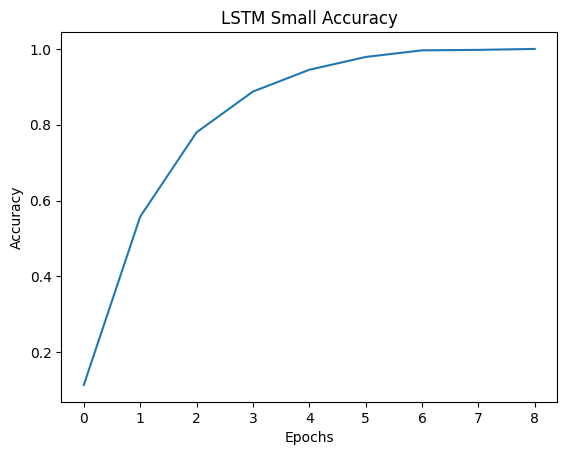

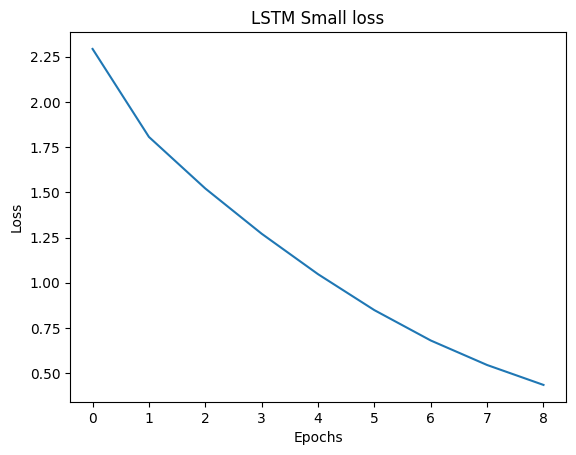

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('LSTM Small Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
#plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('LSTM Small loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
#plt.legend(['train', 'validation'], loc='upper left')
plt.show()


#burrowed from https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

In [ ]:
%cd /content/drive/MyDrive/Extended_Essay/Data_GZAN/mfcc_data
padd_data = True

def get_confusion_matrix():
  # create some empty variables
  correct_classifications_dict = {}
  y_true = []
  y_predictions = []

  # recall the seperate data we loaded from the start
  for music_genre in genre_seperate_data:
    genre_index = music_genres_list.index(music_genre)
    correct_counter = 0

    # load data from that seperate dataset we created earlier
    mfcc_test_features = genre_seperate_data[music_genre]

    # perform predictions
    predictions = mfcc_model.predict(mfcc_test_features)

    # account for padding
    if music_genre == 'classical' and padd_data == True:
      empty_array = np.array([[0,0,0,0,0,1,0,0,0,0]])
      predictions = np.vstack((predictions, empty_array))

    # Finding the index of the maximum value along each prediction scores
    max_indices = np.argmax(predictions, axis=1)

    for predicted_label in max_indices:
      # add to correct counter if scored correctly
      if predicted_label == genre_index:
        correct_counter += 1

      # add to previous dictionaries and list for confusion matrix later
      y_true.append(music_genre)
      y_predictions.append(music_genres_list[predicted_label])


    correct_classifications_dict[music_genre] = correct_counter

  # create the confusion matrix using sklearn
  generated_conf_matrix = sklearn.metrics.confusion_matrix(y_true,y_predictions)

  return generated_conf_matrix, correct_classifications_dict

mfcc_conf_matrix, correct_dict = get_confusion_matrix()
print(mfcc_conf_matrix)
print(correct_dict)

/content/drive/MyDrive/Extended_Essay/Data_GZAN/mfcc_data
4/4 [==============================] - 0s 5ms/step
[[100   0   0   0   0   0   0   0   0   0]
 [  0 100   0   0   0   1   0   0   0   0]
 [  0   0 100   0   0   0   0   0   0   0]
 [  0   0   0 100   0   0   0   0   0   0]
 [  0   0   0   0 100   0   0   0   0   0]
 [  0   0   0   0   0 100   0   0   0   0]
 [  0   0   0   0   0   0 100   0   0   0]
 [  0   0   0   0   0   0   0 100   0   0]
 [ 14  13  22  14   5   7  11  14   0   0]
 [  8  27  18  12   4   8   9  14   0   0]]
{'blues': 100, 'classical': 100, 'country': 100, 'disco': 100, 'hiphop': 100, 'jazz': 100, 'metal': 100, 'pop': 100, 'reggae': 0, 'rock': 0}


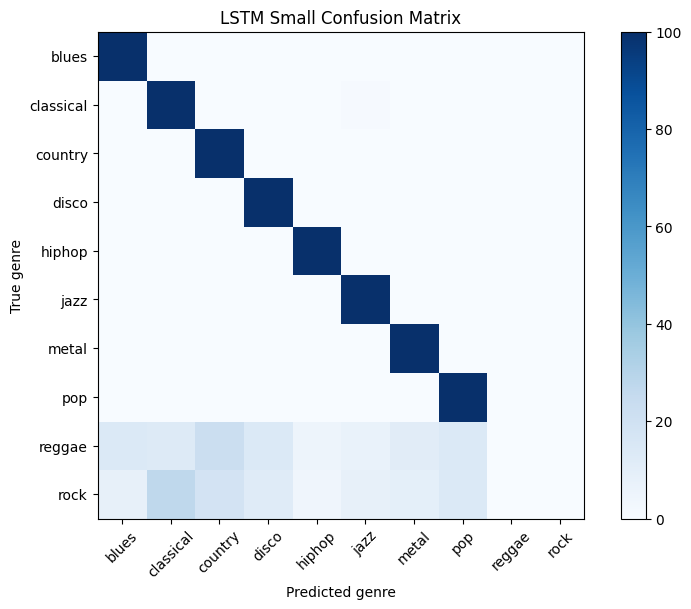

In [ ]:
# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(mfcc_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('LSTM Small Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(music_genres_list))
plt.xticks(tick_marks, music_genres_list, rotation=45)
plt.yticks(tick_marks, music_genres_list)

plt.tight_layout()
plt.ylabel('True genre')
plt.xlabel('Predicted genre')

plt.show()